# Part 2: Polynomial Regression
## Stellar Luminosity with Multiple Features

**Course:** AREP  
**Student:** Samuel Leonardo Albarracin Vergara  
**Date:** 25/01/2026

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(precision=4, suppress=True)

## 2. Dataset

Notation:
- $M$: stellar mass ($M_\odot$)
- $T$: effective temperature (K)
- $L$: luminosity ($L_\odot$)

In [2]:
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

m = len(M)
print(f"Samples: {m}")

Samples: 10


### 2.1 Visualization

Plot L vs M with T encoded as color.

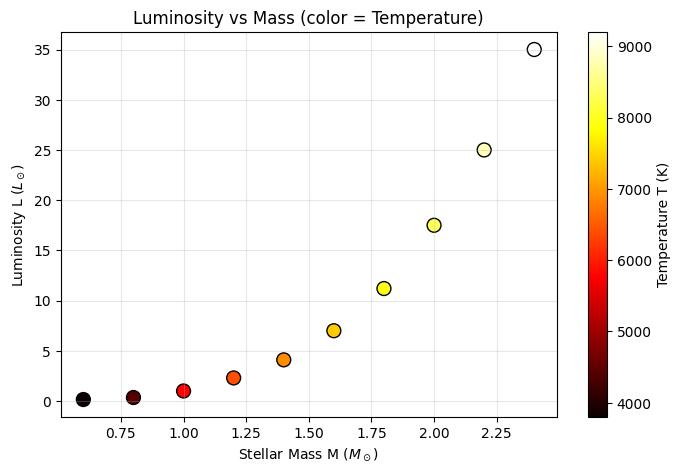

In [3]:
plt.figure(figsize=(8, 5))
scatter = plt.scatter(M, L, c=T, cmap='hot', s=100, edgecolors='black')
plt.colorbar(scatter, label='Temperature T (K)')
plt.xlabel('Stellar Mass M ($M_\odot$)')
plt.ylabel('Luminosity L ($L_\odot$)')
plt.title('Luminosity vs Mass (color = Temperature)')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Feature Engineering

Design matrix with polynomial and interaction terms:
$$X = [M, T, M^2, M \cdot T]$$

Model: $\hat{L} = X \cdot w + b$

In [4]:
def build_features(M, T, model='full'):
    if model == 'M1':
        return np.column_stack([M, T])
    elif model == 'M2':
        return np.column_stack([M, T, M**2])
    else:  # M3 - full
        return np.column_stack([M, T, M**2, M*T])

X_full = build_features(M, T, 'full')
print(f"Design matrix shape: {X_full.shape}")
print(f"Features: [M, T, M^2, M*T]")
print(X_full[:3])

Design matrix shape: (10, 4)
Features: [M, T, M^2, M*T]
[[   0.6  3800.      0.36 2280.  ]
 [   0.8  4400.      0.64 3520.  ]
 [   1.   5800.      1.   5800.  ]]


### 3.1 Feature Scaling

In [5]:
def feature_scale(X):
    means = X.mean(axis=0)
    stds = X.std(axis=0)
    X_scaled = (X - means) / stds
    return X_scaled, means, stds

X_scaled, X_means, X_stds = feature_scale(X_full)
print("Means:", X_means)
print("Stds:", X_stds)

Means: [    1.5   6890.       2.58 11304.  ]
Stds: [   0.5745 1715.4883    1.7477 6371.9121]


## 4. Loss and Gradients (Vectorized)

MSE: $J(w,b) = \frac{1}{2m} \sum (\hat{L} - L)^2$

Gradients:
$$\nabla_w J = \frac{1}{m} X^T (\hat{L} - L)$$
$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum (\hat{L} - L)$$

In [6]:
def predict(X, w, b):
    return X @ w + b

def compute_cost(X, L, w, b):
    m = X.shape[0]
    error = predict(X, w, b) - L
    return (error @ error) / (2 * m)

def compute_gradient(X, L, w, b):
    m = X.shape[0]
    error = predict(X, w, b) - L
    dj_dw = (X.T @ error) / m
    dj_db = np.sum(error) / m
    return dj_dw, dj_db

## 5. Gradient Descent

In [7]:
def gradient_descent(X, L, w_init, b_init, alpha, iterations, verbose=False):
    w = w_init.copy()
    b = b_init
    cost_history = []
    
    for i in range(iterations):
        dj_dw, dj_db = compute_gradient(X, L, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        cost = compute_cost(X, L, w, b)
        cost_history.append(cost)
        
        if verbose and i % 500 == 0:
            print(f"Iter {i}: cost = {cost:.6f}")
    
    return w, b, cost_history

In [8]:
n_features = X_scaled.shape[1]
w_init = np.zeros(n_features)
b_init = 0.0

w_final, b_final, cost_history = gradient_descent(X_scaled, L, w_init, b_init, alpha=0.1, iterations=3000, verbose=True)

print(f"\nFinal w: {w_final}")
print(f"Final b: {b_final:.4f}")
print(f"Final cost: {cost_history[-1]:.6f}")

Iter 0: cost = 72.438211
Iter 500: cost = 0.979338
Iter 1000: cost = 0.869814
Iter 1500: cost = 0.789481
Iter 2000: cost = 0.719735
Iter 2500: cost = 0.659125

Final w: [-7.7925 -5.06   17.0113  6.4543]
Final b: 10.3600
Final cost: 0.606525


### 5.1 Convergence Plot

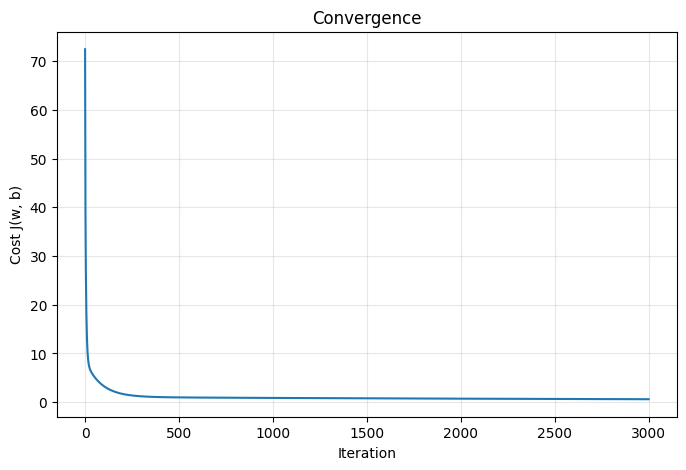

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost J(w, b)')
plt.title('Convergence')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Feature Selection Experiment

Comparing three models:
- M1: X = [M, T]
- M2: X = [M, T, M²]
- M3: X = [M, T, M², M·T]

In [10]:
models = ['M1', 'M2', 'full']
model_names = ['M1: [M, T]', 'M2: [M, T, M²]', 'M3: [M, T, M², M·T]']
results = {}

for model, name in zip(models, model_names):
    X_model = build_features(M, T, model)
    X_model_scaled, means, stds = feature_scale(X_model)
    
    w_init = np.zeros(X_model_scaled.shape[1])
    w, b, history = gradient_descent(X_model_scaled, L, w_init, 0.0, alpha=0.1, iterations=3000)
    
    results[model] = {
        'w': w,
        'b': b,
        'cost': history[-1],
        'X_scaled': X_model_scaled,
        'means': means,
        'stds': stds
    }
    
    print(f"{name}")
    print(f"  w = {w}")
    print(f"  b = {b:.4f}")
    print(f"  Final cost = {history[-1]:.6f}")
    print()

M1: [M, T]
  w = [ 29.335  -19.2444]
  b = 10.3600
  Final cost = 3.553129

M2: [M, T, M²]
  w = [-5.9059 -4.1969 20.7633]
  b = 10.3600
  Final cost = 0.592179

M3: [M, T, M², M·T]
  w = [-7.7925 -5.06   17.0113  6.4543]
  b = 10.3600
  Final cost = 0.606525



### 6.1 Predicted vs Actual for Each Model

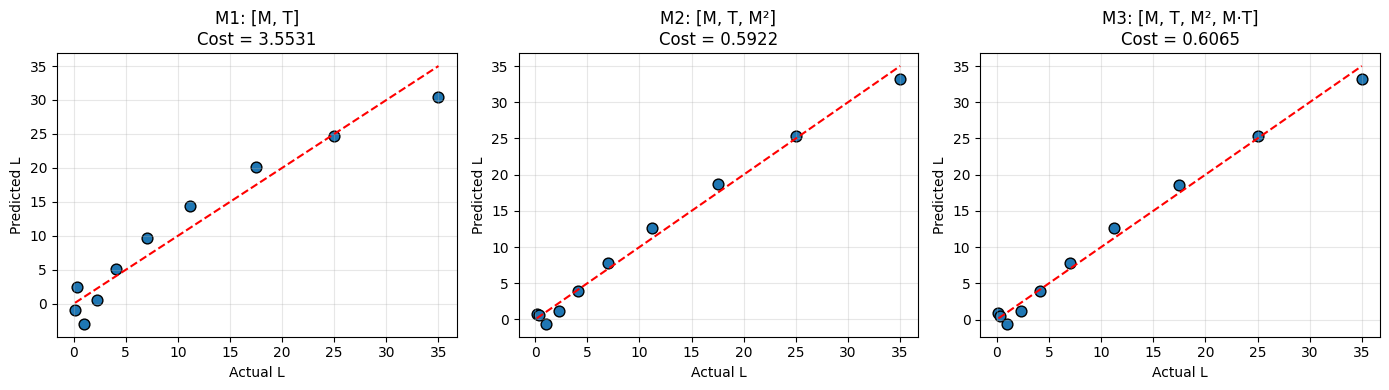

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (model, name) in zip(axes, zip(models, model_names)):
    r = results[model]
    L_pred = predict(r['X_scaled'], r['w'], r['b'])
    
    ax.scatter(L, L_pred, s=60, edgecolors='black')
    ax.plot([L.min(), L.max()], [L.min(), L.max()], 'r--')
    ax.set_xlabel('Actual L')
    ax.set_ylabel('Predicted L')
    ax.set_title(f"{name}\nCost = {r['cost']:.4f}")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Cost vs Interaction Coefficient

For the full model (M3), we vary $w_{MT}$ (the interaction coefficient) while keeping other parameters fixed at their trained values.

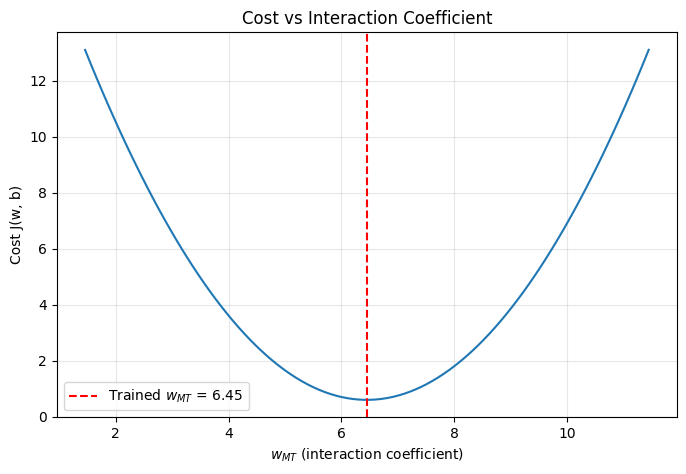

In [12]:
r_full = results['full']
w_trained = r_full['w'].copy()
b_trained = r_full['b']
X_full_scaled = r_full['X_scaled']

w_MT_range = np.linspace(w_trained[3] - 5, w_trained[3] + 5, 100)
costs = []

for w_MT in w_MT_range:
    w_test = w_trained.copy()
    w_test[3] = w_MT
    cost = compute_cost(X_full_scaled, L, w_test, b_trained)
    costs.append(cost)

plt.figure(figsize=(8, 5))
plt.plot(w_MT_range, costs)
plt.axvline(w_trained[3], color='r', linestyle='--', label=f'Trained $w_{{MT}}$ = {w_trained[3]:.2f}')
plt.xlabel('$w_{MT}$ (interaction coefficient)')
plt.ylabel('Cost J(w, b)')
plt.title('Cost vs Interaction Coefficient')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Interpretation:**

The parabolic shape shows that the cost is sensitive to the interaction coefficient. The minimum occurs at the trained value, confirming that gradient descent found the optimal $w_{MT}$. The curvature indicates the interaction term contributes to the model; if it were flat, the interaction would be irrelevant.

## 8. Inference Demo

Predict luminosity for a new star with M = 1.3 $M_\odot$ and T = 6600 K.

In [13]:
M_new = 1.3
T_new = 6600

X_new = np.array([[M_new, T_new, M_new**2, M_new*T_new]])
X_new_scaled = (X_new - r_full['means']) / r_full['stds']

L_pred_new = predict(X_new_scaled, r_full['w'], r_full['b'])[0]

print(f"Input: M = {M_new} M_sun, T = {T_new} K")
print(f"Predicted luminosity: L = {L_pred_new:.2f} L_sun")

Input: M = 1.3 M_sun, T = 6600 K
Predicted luminosity: L = 2.51 L_sun


**Comment on reasonableness:**

The predicted value falls between the training samples with M=1.2 (L=2.30) and M=1.4 (L=4.10), which makes sense for interpolation. The temperature of 6600 K is also consistent with a star slightly more massive than the Sun. The prediction appears physically reasonable.